<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

# AC SAF - Near-real time (NRT) and Offline (Level 2) products

AC SAF Level 2 data products are available as `near-real time (NRT)` and `offline`. NRT data products are available within three hours from sensing for the past two months. Offline products are available within 15 days from sensing at latest, but typical is a delay of 2-3 days.  AC SAF Level 2 data are disseminated in `HDF5` data format.

### Load required libraries

In [479]:
import os
import h5py
from netCDF4 import Dataset, MFDataset
import xarray as xr
import numpy as np
import pandas
import datetime

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy

from IPython.display import display, clear_output

In [4]:
os.chdir('/Users/julia_wagemann/Documents/github/ltpy/sample_data/level2_case_studies/2019_amazonas_fires/')

<hr>

## Load and browse AC SAF Level 2 products

[h5py](http://docs.h5py.org/en/stable/) is a Python library that let's you access and manipulate data sets in HDF5 data format.

### Structure of AC SAF Level 2 product data files

The data in the HDF5 file is organized in five groups:
* META_DATA
 * Product Metadata
* GEOLOCATION
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* TOTAL_COLUMNS
 * Total and tropospheric column amounts of the various trace gases with corresponding (relative) errors
* DETAILED_RESULTS
 * Geophysical parameters (surface, cloud and aerosol values)
 * Vertical column, slant column, and AMF values with corresponding errors
 * Fittings diagnostics (chi-square, RMS, etc.)
 * Various subgroups for trace gas specific data (e.g. O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, etc.)
* CLOUD_PROPERTIES
 * Retrieve cloud properties

<br>

### Load HDF5 data with h5py

A HDF5 file can be openend with the `File` function of the h5py package. The read attribute `r` gives read permission, but does not overwrite the original data file. The file object acts like a Python dictionary. Thus, the `keys` function allows us to see the different groups the file contains.

In [3]:
file = h5py.File('./gome2a/20190818/offline/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20190818000913_050_METOPA_66564_DLR_04.HDF5', 'r')
groups = sorted(file.keys())
groups

['CLOUD_PROPERTIES',
 'DETAILED_RESULTS',
 'GEOLOCATION',
 'META_DATA',
 'TOTAL_COLUMNS']

<br>

Each group contains multiple variables. We can print out all variables of each group nicely formatted. This gives us a helpful overview of available parameters. We are mostly interested in parameters of the `GEOLOCATION` and `TOTAL_COLUMNS` groups.

We see that one AC SAF Level 2 data file contains trace gas total columns of six parameters:
* `BrO` - Hypobromite
* `H`<sub>`2`</sub>`O` - Water vapour
* `HCHO` - Formaldehyde
* `NO`<sub>`2`</sub> - Nitrogen Dioxide
* `O`<sub>`3`</sub> - Ozone
* `SO`<sub>`2`</sub> - Sulfur Dioxide

Additionally, the data file contains the tropospheric vertical column of Nitrogen Dioxide:
* `NO`<sub>`2`</sub> `Tropo` - Tropospheric Nitrogen Dioxide

In [4]:
 for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(file[group].keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

CLOUD_PROPERTIES:
   - CloudFraction                 - CloudFraction_Error           - CloudMode
   - CloudOpticalThickness         - CloudOpticalThickness_Error   - CloudTopAlbedo
   - CloudTopAlbedo_Error          - CloudTopHeight                - CloudTopHeight_Error
   - CloudTopPressure              - CloudTopPressure_Error        - CloudType
   - PMDCloudFraction              

DETAILED_RESULTS:
   - AAI                           - AMFToCloudTop                 - AMFToCloudTop_Error
   - AMFToGround                   - AMFToGround_Error             - AMFTotal
   - AMFTotal_Error                - BrO                           - Clouds
   - ESC                           - ESC_Error                     - FittingChiSquare
   - FittingGoodness               - FittingNumberOfIterations     - FittingRMS
   - H2O                           - HCHO                          - IntensityWeightedCloudFraction
   - NO2                           - O3                            - QualityFlags
   -

### Select and retrieve one specific parameter from a HDF5 file group

Let's say, we are interested in the Total vertical column density of Nitrogen-Dioxide (NO<sub>2</sub>). We can retrieve the parameter values by selecting the internal path of the data file: `TOTAL_COLUMNS/NO2`. The resulting object is a HDF5 dataset, which has a shape of a 1-dimensional vector.

In [5]:
no2 = file['TOTAL_COLUMNS/NO2']
no2

<HDF5 dataset "NO2": shape (15149,), type "<f4">

<br>

Attributes of the NO<sub>2</sub> object can be accessed with the `attrs` function. Atrributes are  helpful to better understand the parameter, e.g. we get information about minimum and maximum values of the parameter and the unit of the data values.

In [6]:
dict(no2.attrs)

{'Unit': array([b'mol/cm2'], dtype='|S7'),
 'Title': array([b'Initial total vertical column density of NO2'], dtype='|S44'),
 'FillValue': array([-1.], dtype=float32),
 'CheckSum': array([1422493241], dtype=int32),
 'ValueRangeMin': array([-5.644477e+14], dtype=float32),
 'ValueRangeMax': array([8.447582e+15], dtype=float32)}

<br>

Data values can be accessed with the `value` function, which returns the data values as a numpy array.

In [7]:
no2.value

array([5.1484766e+15, 5.1833657e+15, 5.2770534e+15, ..., 1.3682060e+15,
       1.4400180e+15, 1.4516806e+15], dtype=float32)

<br>

## Build a xarray `DataArray` object for a AC SAF Level 2 parameter

For easier handling and plotting of the parameters, we combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

The constructor takes:
* `data`: an array of values (can be e.g. a numpy ndarray, but also a `Series`, `DataFrame` or `Panel`)
* `dims`: a list of dimension names
* `coords`: a list or dictionary of coordinates
* `attrs`: a dictionary of attributes to add to the instance

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` instance with latitude and longitude information and the NO<sub>2</sub> values as data values. The `DataArray` object contains around 15 000 ground pixels.

In [8]:
latitude = file['GEOLOCATION/LatitudeCentre']
longitude = file['GEOLOCATION/LongitudeCentre']

no2_da = xr.DataArray(
    no2.value,
    dims=('ground_pixel'),
    coords={
        'latitude': ('ground_pixel', latitude[:]),
        'longitude': ('ground_pixel', longitude[:])
    },
    attrs={'long_name': 'Vertical column density of NO2', 'units': 'mol/cm2'},
    name='vertical_column_NO2'
)

no2_da

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 15149)>
array([5.148477e+15, 5.183366e+15, 5.277053e+15, ..., 1.368206e+15,
       1.440018e+15, 1.451681e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.487015 63.81676 ... -62.004383
    longitude  (ground_pixel) float32 293.3269 293.0064 ... 105.10608 106.36275
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

### Plotting example of AC SAF Level 2 products - Single file with `PlateCarree` projection

We can continue to plot (visualize) the `DataArray` object. Python provides several plotting libraries. One extensive plotting library is [matplotlib](https://matplotlib.org/).

[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is another useful Python package. Key features of `cartopy` are its object-oriented [projection definitions](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html), and its ability to transform points, lines, vectors, polygons and images between those projections. Cartopy includes a programmatic interface built on top of Matplotlib for the creation of publication quality maps.

As basemap, we create a map in a `PlateCarree` projection. We add coast- and gridlines. On top of the basemap, we plot the NO<sub>2</sub> values as a scatter plot, with the `scatter` function. As we might need to reuse the code for plotting, we define a plotting function called `visualize_gome_l2`.

In [478]:
def visualize_gome_l2(xr_dataarray, conversion_factor, projection, vmin, vmax, set_global=False):
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=projection)

    ax.coastlines()
    if set_global:
        ax.set_global()
    # set gridlines
#    ax.gridlines()
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap('gist_rainbow_r'),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

The example above shows that one individual file contains the data for only one ground track. If we want to see all the data that has been sensed on one individual day, we have to combine multiple HDF5 files.

<br>

## Combine multiple HDF5 files in a xarray `DataArray` object

AC SAF Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, we can combine the steps above in a for loop:

* 1) Open the HDF5 file with `h5py.File` <br>
* 2) Retrieve information on `GEOLOCATION` and the `TOTAL_COLUMNS` parameter of interest
* 3) Generate a xarray `DataArray` and store it in a list of DataArrays
* 4) Concatenate the the DataArrays into one `DataArray` with `xarray.concat`

We combined the steps above in a function `load_l2_data_xr`.

The result is a 1-dimensional `DataArray` containing the ground pixels of all GOME-2A files for one specific day. We see that the `DataArray` object contains now multiple 100 000 ground pixels.

In [229]:
def load_l2_data_xr(directory, internal_filepath, parameter, longname, unit, name):
    fileList = os.listdir(directory)
    datasets = []

    for i in fileList:
        fullpath=os.path.join(directory, i)
        tmp = h5py.File(fullpath, 'r')
        groups =tmp.keys()
        tmp[internal_filepath]
        latitude = tmp['GEOLOCATION/LatitudeCentre']
        longitude = tmp['GEOLOCATION/LongitudeCentre']
        param = tmp[internal_filepath+'/'+parameter]
        da_tmp = xr.DataArray(
            param.value,
            dims=('ground_pixel'),
            coords={
                'latitude': ('ground_pixel', latitude[:]),
                'longitude': ('ground_pixel', longitude[:])
            },
            attrs={'long_name': longname, 'units': unit},
            name=name
        )
        datasets.append(da_tmp)

    return xr.concat(datasets, dim='ground_pixel')

In [321]:
directory_2a = './gome2a/20190818/offline/'
no2_a_da_mf = load_l2_data_xr(directory, 'TOTAL_COLUMNS', 'NO2', 'Vertical column density of NO2', 'mol/cm2', 'vertical_column_NO2')
no2_a_da_mf

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 223224)>
array([4.875167e+15, 4.960817e+15, 4.822046e+15, ..., 9.432375e+14,
       1.027723e+15, 9.024748e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.87075 64.20003 ... -61.54535 -62.054047
    longitude  (ground_pixel) float32 90.22523 89.898026 ... 29.047194 30.302885
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

### Plotting example of AC SAF Level 2 products - Multiple files with `Mollweide` projection

The plotting example above showed that the `PlateCarree` projection is not the best suited projection for representing the GOME-2 ground tracks. Thus, all ground tracks of one day, we want to visualize in `Mollweide` projection. We change our basemap to the `Mollweide` projection and add a transform argument to our scatter plot, in order to transform our coordinates to a `Mollweide` projection.

We define the function `visualize_gome_mollweide` to visualize the data in a `Mollweide` projection, which is more appropriate to visualize the ground tracks.

In [252]:
def visualize_gome_mollweide(xr_dataarray, conversion_factor, vmin, vmax):
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=ccrs.Mollweide())

    ax.coastlines()
    ax.set_global()

    ax.gridlines(linestyle='--')
    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap('gist_rainbow_r'),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

<br>

Let's visualize the ground tracks of all the measured values of MetOp-A for 18 August 2019. We see that the unfiltered data may contain negative values. Measurements can further be influenced by clouds. Thus, the next step is to mask the data and filter invalid ground pixels.

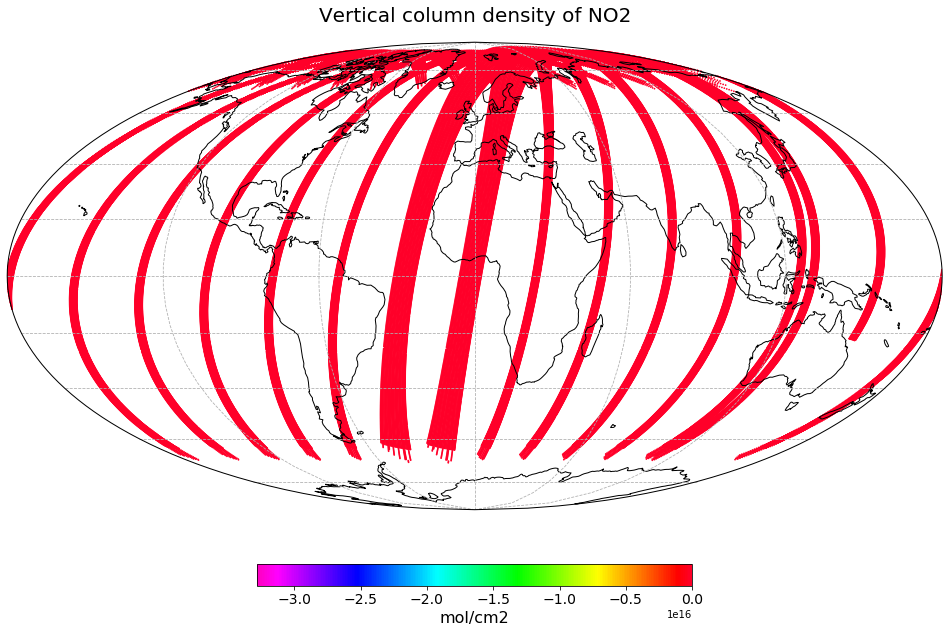

In [246]:
visualize_gome_mollweide(no2_a_da_mf, 1e-15, no2_a_da_mf.data.min(), no2_a_da_mf.data.max())

<br>

## Data masking

AC SAF Level 2 data provide valuable information on the quality and validity of the measured data. Different conditions can influence the measured values:
* As we see above, negative values can occur, which are not valid
* Clouds fractions influence the measured values and lead to errors, and
* other conditions that might make the measured data invalid, e.g. an unsuccessful fitting of the slant column.

Thus, we have to mask the only valid ground pixels.

### Flag negative values

In [322]:
no2_a_da_mf_flagged = no2_a_da_mf[no2_a_da_mf > 0]
no2_a_da_mf_flagged

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 222820)>
array([4.875167e+15, 4.960817e+15, 4.822046e+15, ..., 9.432375e+14,
       1.027723e+15, 9.024748e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.87075 64.20003 ... -61.54535 -62.054047
    longitude  (ground_pixel) float32 90.22523 89.898026 ... 29.047194 30.302885
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

Negative values can be flagged by `casting` our `DataArray` for all positive values. We see that the minimum of our `DataArray` is not negative anymore. Visualizing the `DataArray` shows a more detailed representation of the total column NO<sub>2</sub>. Filtering simply the negative values is just one part. Another important part to filter invalid pixels is to mask all ground pixels that are covered with clouds.

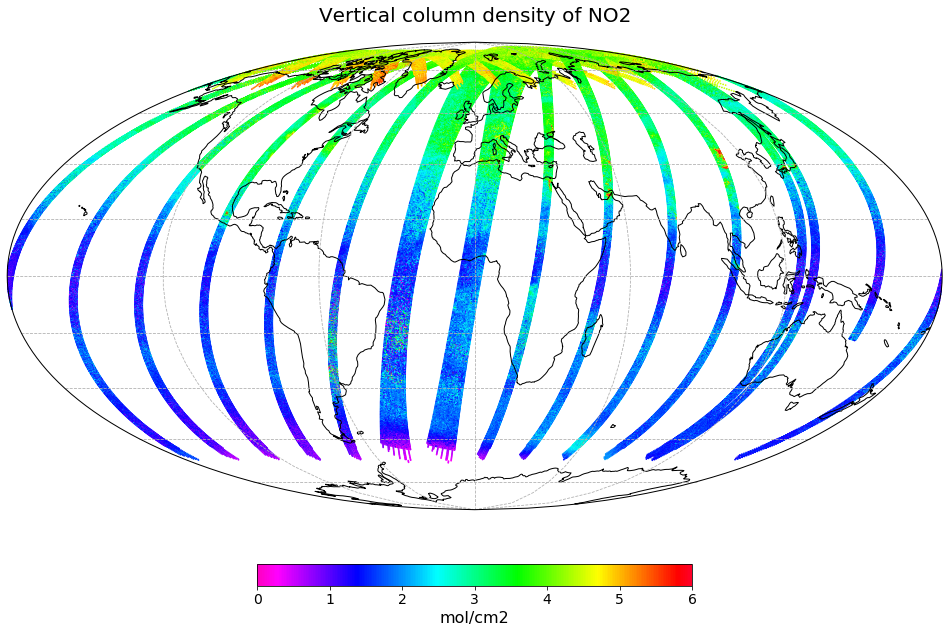

In [323]:
visualize_gome_mollweide(no2_a_da_mf_flagged, 1e-15, vmin=0, vmax=6)

### Cloud masking

AC SAF Level 2 data provide under the `CLOUD_PROPERTIES` group information on the `CloudFraction` for each ground pixel. The first step is to generate a cloud mask we can apply to our total column data array. We therefore load the cloud fraction property with the `load_l2_data_xr` function.

In [324]:
cloud_fraction_2a = load_l2_data_xr(directory_2a, 'CLOUD_PROPERTIES', 'CloudFraction', unit='-', longname='Cloud Fraction', name='cloud_fraction')
cloud_fraction_2a

<xarray.DataArray 'cloud_fraction' (ground_pixel: 223224)>
array([0.576101, 0.601783, 0.620129, ..., 1.      , 1.      , 0.920525],
      dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.87075 64.20003 ... -61.54535 -62.054047
    longitude  (ground_pixel) float32 90.22523 89.898026 ... 29.047194 30.302885
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

With xarray's function `where`, we can generate a cloud mask, by specifying e.g. each ground pixel with a `CloudFraction` higher than 50% to classify as unvalid (mask value = 0). The resulting mask has value 1 for ground pixels we want to keep and value 0 for ground pixels we want to drop. Xarray's `where` function helps as well to apply the cloud mask to our `DataArray`. We want to keep the ground pixels where the cloud mask is 1 and we want to drop the rest.

The function `generate_masked_array` combines all steps of `cloud masking`. The masked array, where negative values were filtered out, is returned. We see that the number of valid ground pixels decreased from over 200 000 to less than 140 000.

In [317]:
def generate_masked_array(xarray, mask, threshold):
    cloud_mask = xr.where(mask < threshold, 1, 0)
    xarray_masked = xr.where(cloud_mask ==1, xarray, 0)
    xarray_masked.attrs = xarray.attrs
    return xarray_masked[xarray_masked > 0]

In [325]:
no2_a_da_masked = generate_masked_array(no2_a_da_mf, cloud_fraction_2a, 0.5)
no2_a_da_masked

<xarray.DataArray (ground_pixel: 139449)>
array([4.794864e+15, 4.983427e+15, 4.789247e+15, ..., 1.420823e+15,
       1.307916e+15, 1.284063e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.31718 65.64828 ... -60.07173 -60.40655
    longitude  (ground_pixel) float32 91.21137 90.88129 ... 28.227266 27.97421
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

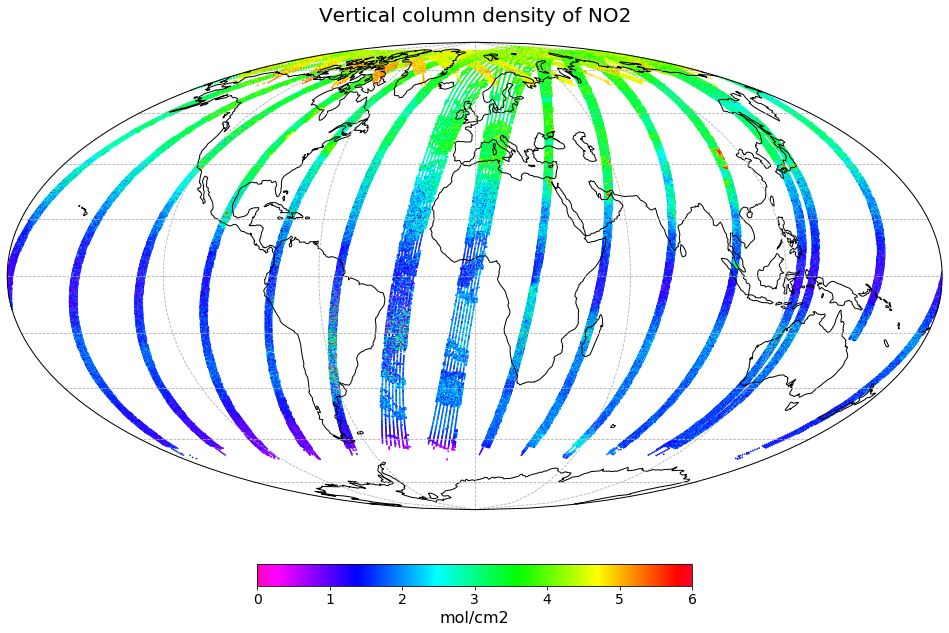

In [326]:
visualize_gome_mollweide(no2_a_da_masked, 1e-15, vmin=0, vmax=6)

<br>

## Combine Metop-A and Metop-B data files

The above examples show that Metop-A data have many parts on Earth unsensed. Metop-A data can be combined with Metop-B ground pixel for one specific day in order to increase the overall coverage. Metop-B has a wider nominal resolution than Metop-A.

Since we already concatenated and filtered the ground pixel values for day 18 Aug 2019 for Metop-A GOME Level 2 data, we only have to repeat the same pre-processing steps for the Metop-B data files:

1. Load total column NO<sub>2</sub> values with `load_l2_data_xr` function 
2. Load cloud fraction information with `load_l2_data_xr` 
3. Filter unvalid ground pixels with `generate_masked_array`
4. Visualize the masked array with `visualize_gome_mollweide`.

#### 1. Load total column NO<sub>2</sub> values from MetOp-B

In [327]:
directory_2b= './gome2b/20190818/offline/'
no2_b_da_mf = load_l2_data_xr(directory_2b, 'TOTAL_COLUMNS', 'NO2', 'Vertical column density of NO2', 'mol/cm2','vertical_column_NO2')
no2_b_da_mf

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 211316)>
array([4.253578e+15, 4.253952e+15, 4.290962e+15, ..., 1.657894e+15,
       1.713913e+15, 1.769028e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 62.95204 63.251656 ... -68.07183
    longitude  (ground_pixel) float32 193.75484 193.30927 ... 158.388 158.22429
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

#### 2. Load cloud fraction information

In [308]:
cloud_fraction_2b = load_l2_data_xr(directory_2b,'CLOUD_PROPERTIES','CloudFraction',unit='-', longname='Cloud Fraction', name='cloud_fraction') 
cloud_fraction_2b

<xarray.DataArray 'cloud_fraction' (ground_pixel: 211316)>
array([0.856058, 0.859357, 0.852944, ..., 0.663486, 0.660541, 0.661271],
      dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 62.95204 63.251656 ... -68.07183
    longitude  (ground_pixel) float32 193.75484 193.30927 ... 158.388 158.22429
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

#### 3. Mask data array

In [328]:
no2_b_da_masked = generate_masked_array(no2_b_da_mf, cloud_fraction_2b, 0.5)
no2_b_da_masked

<xarray.DataArray (ground_pixel: 127515)>
array([4.795930e+15, 4.613971e+15, 5.140958e+15, ..., 1.304931e+15,
       1.214247e+15, 1.767904e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 68.342766 68.65656 ... -59.936657
    longitude  (ground_pixel) float32 197.88329 197.40623 ... 143.98865
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

#### 4. Visualization of masked MetOp-B Total column NO2 ground pixels

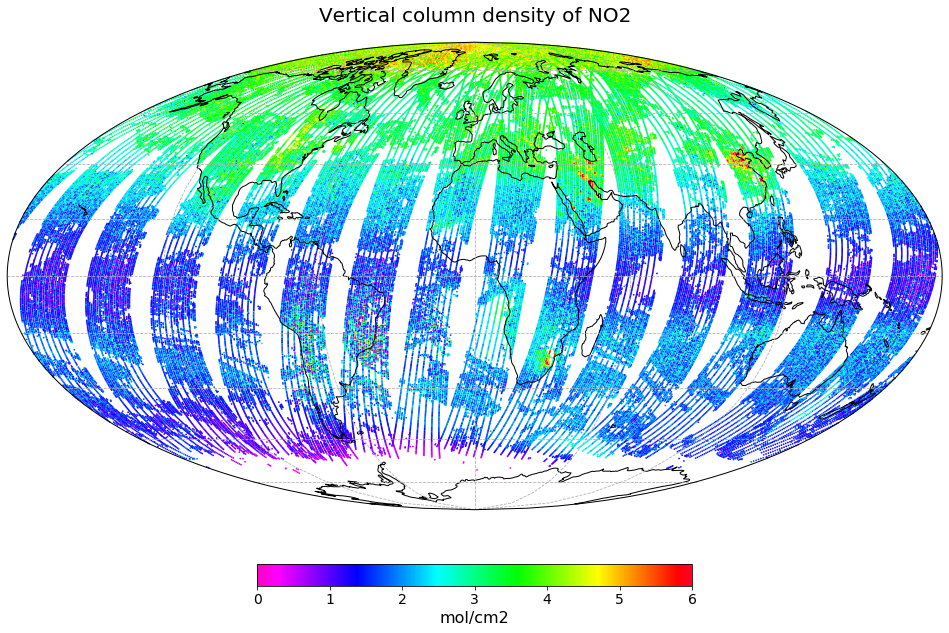

In [330]:
visualize_gome_mollweide(no2_b_da_masked, 1e-15, vmin=0, vmax=6)

<br>

### Combine masked `DataArrays` with `xarray.concat`

To combine data from Metop-A and Metop-B, we have to concatenate both `DataArrays` with `xarray.concat`. The resulting `DataArray` object has more than 250 000 ground pixel values. With the `visualize_gome_mollweide` function, we can visualize the combined `DataArray`.

In [331]:
no2_ab_da_masked = xr.concat([no2_a_da_masked, no2_b_da_masked], dim='ground_pixel')
no2_ab_da_masked

<xarray.DataArray (ground_pixel: 266964)>
array([4.794864e+15, 4.983427e+15, 4.789247e+15, ..., 1.304931e+15,
       1.214247e+15, 1.767904e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.31718 65.64828 ... -59.936657
    longitude  (ground_pixel) float32 91.21137 90.88129 ... 145.32582 143.98865
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

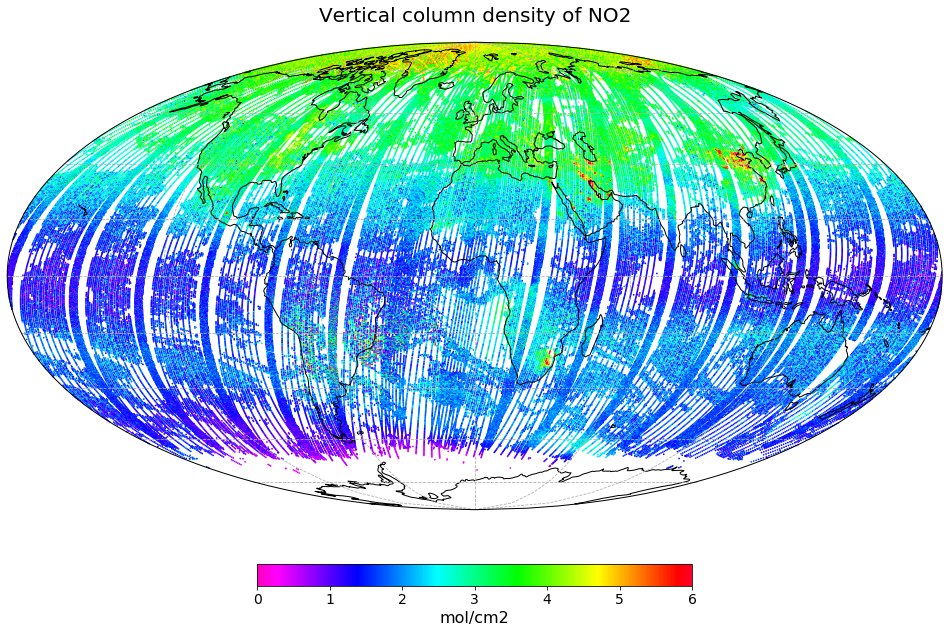

In [333]:
visualize_gome_mollweide(no2_ab_da_masked, 1e-15, vmin=0, vmax=6)

<br>

## Select geographical subset

We can generate a `geographical subset` of our `DataArray` to get a more detailed information about a specific region for example. The subset can easily be created with xarray's function `where`, where for latitude and longitude a minimum and maximum threshold can be assigned. By using the `drop` argument, we drop the data values for wich the condition is False.

There is one caveat: the `longitude` values of the AC SAF Level 2 data are stored as 0 to 360-degrees longitude. Thus, if we want to select the geographical subset based on a geographical bounding box of -180 to 180 degrees, we have to convert the `latitude` values. This is done by newly assigning the `longitude` values with the `assign_coords` function.

In [494]:
no2_ab_da_masked = no2_ab_da_masked.assign_coords(longitude=(((no2_ab_da_masked.longitude + 180) % 360) - 180))

#### Select the bounding box with xarray's `where` function

Let's select a bounding box over South America and parts of Central and Southern Africa with the following latitude and longtidue boundaries:
* `latitude`: -60 deg to 15 deg
* `longitude`: -80 deg to 40 deg

In [500]:
no2_ab_da_subset = no2_ab_da_masked.where((no2_ab_da_masked.latitude < 15) & (no2_ab_da_masked.latitude > -60) & (no2_ab_da_masked.longitude < 40) & (no2_ab_da_masked.longitude > -80),drop=True)
no2_ab_da_subset

<xarray.DataArray (ground_pixel: 38793)>
array([2.421112e+15, 2.586344e+15, 2.190222e+15, ..., 5.966626e+14,
       4.009991e+14, 3.150726e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 14.973023 14.907713 ... -59.793495
    longitude  (ground_pixel) float32 -73.150604 -72.91504 ... -34.752777
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

We can now visualize the geographic subset with the defined function `visualize_gome_l2`, which represents the subset in a `PlateCarree` projection.

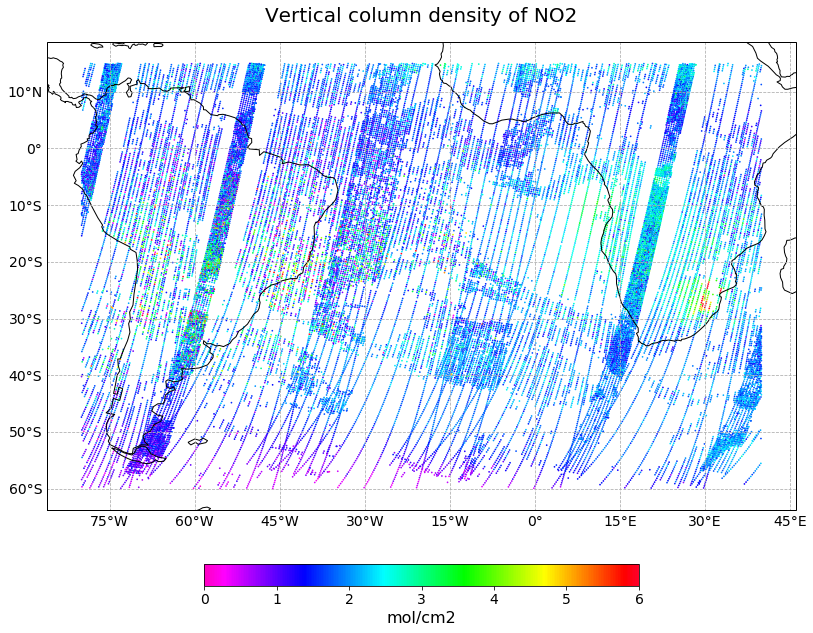

In [501]:
visualize_gome_l2(no2_ab_da_subset,1e-15, ccrs.PlateCarree(),vmin=0,vmax=6,set_global=False)

<hr>

<p style="text-align:left;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/blob/master/LICENSE">&copy; Copyright 2019 eo-lab</a> <span style="float:right;">View on GitLab | Cite | Contact</span></p>